In [1]:
import math, random
import itertools
import collections

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [2]:
CUDA_status = torch.cuda.is_available()
print(CUDA_status)
Tensor = lambda argument: torch.cuda.tensor(argument) if CUDA_status else torch.tensor(argument)
FloatTensor = lambda argument: torch.cuda.FloatTensor(argument) if CUDA_status else torch.FloatTensor(argument)
LongTensor = lambda argument: torch.cuda.LongTensor(argument) if CUDA_status else torch.LongTensor(argument)

True


In [3]:
class ExperienceReplay(object):
    
    def __init__(self, maxSize):
        self.maxSize = maxSize
        self.replayBuffer = collections.deque(maxlen=maxSize)
    
    def append(self, state, action, reward, next_state, done):
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)
        self.replayBuffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return zip(*random.sample(self.replayBuffer, batch_size))
    
    def length(self):
        return len(self.replayBuffer)

In [4]:
experience_replay = ExperienceReplay(40000)

In [5]:
env_id = "gym_stage_2:foo-v2"
env = gym.make(env_id)

In [6]:
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 5000

In [7]:
def epsilon_by_frame(frame):
    return min_epsilon + (max_epsilon - min_epsilon) * math.exp(-1. * frame / epsilon_decay)

In [8]:
class DQNAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQNAgent, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        
        self.network = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.network(x)
    
    def takeAction(self, state, epsilon):
        action = random.randint(0, self.num_actions-1)
        if random.random() > epsilon:
            with torch.no_grad():
                state  = FloatTensor(state[0]).unsqueeze(0)
                action = self.forward(state).max(1)[1].data.item()
        return action
    
    def update_network(self, online_network):
        self.load_state_dict(online_network.state_dict())
        
    def train_td(self, opt, target_network, batch_size):
        state, action, reward, next_state, done = experience_replay.sample(batch_size)
        
        state      = FloatTensor(np.float32(state))
        with torch.no_grad():
            next_state = FloatTensor(np.float32(next_state))
        action     = LongTensor(action)
        reward     = FloatTensor(reward)
        done       = FloatTensor(done)

        Qvalues      = self.forward(state)
        nextQvalues = target_network.forward(next_state)

        Qvalues          = Qvalues.gather(1, action.unsqueeze(1)).squeeze(1)
        nextQvalues     = nextQvalues.max(1)[0]
        Qvalues_1 = reward + gamma * nextQvalues * (1 - done)

        loss = (Qvalues - Qvalues_1.data).pow(2).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()

        return loss

In [32]:
online_network = DQNAgent(env.observation_space.shape[0], env.action_space.n).cuda() if CUDA_status else DQNAgent(env.observation_space.shape[0], env.action_space.n)
target_network = DQNAgent(env.observation_space.shape[0], env.action_space.n).cuda() if CUDA_status else DQNAgent(env.observation_space.shape[0], env.action_space.n)

target_network.update_network(online_network)
optimizer = optim.Adam(online_network.parameters())

In [33]:
def plot(frame_idx, rewards, losses, final_rewards, episode_rewards):
    clear_output(True)
    plt.figure(figsize=(20,12))
    plt.subplot(221)
    plt.title('frame %s. reward: %s. epsilon %s' % (frame_idx, np.mean(rewards[-10:]), epsilon))
    plt.plot(rewards)
    plt.subplot(222)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(223)
    plt.title('Final rewards')
    plt.plot(final_rewards)
    plt.subplot(224)
    plt.title('Episode rewards')
    plt.plot(episode_rewards)
    plt.show()

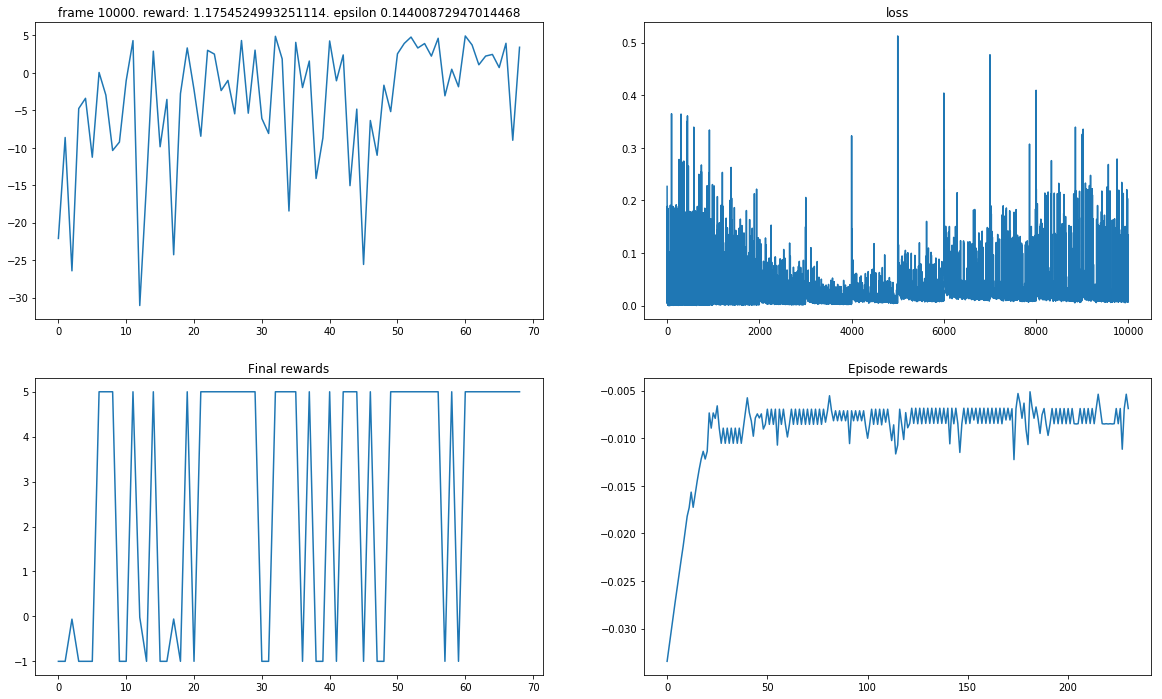

epsilon:  0.14400872947014468
Succeeded num of :  43


KeyboardInterrupt: 

In [34]:
num_frames = 1000000
batch_size = 256
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

episode_reward_array = []
final_rewards = []

num_of_success = 0

state = env.reset()
frames_per_episode = 0
frame_for_epsilon = 0

finish_randomness = 0


for frame_idx in range(1, 1+num_frames):
    #env.render()
    epsilon = epsilon_by_frame(frame_for_epsilon)
    action = online_network.takeAction(state, epsilon)
    next_state, reward, done, succeeded, reset_frame_for_episode = env.step(action)
    experience_replay.append(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward
    episode_reward_array.append(reward)

    frames_per_episode += 1
    frame_for_epsilon += 1
    
    if reset_frame_for_episode:
        finish_randomness += 1
        #if finish_randomness < 9:
        #    frame_for_epsilon = 0
        #    #print("HI")
        #else: 
        #    print("No randomness anymore")
        #    break
    if succeeded:
        num_of_success += 1
    if done or frames_per_episode == 500:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward_array = []
        episode_reward = 0
        frames_per_episode = 0
        if reward >0 or reward < 0:
            final_rewards.append(reward)
        else: 
            final_rewards.append(0)
    if frame_idx % 5000 == 0:
        plot(frame_idx, all_rewards, losses, final_rewards, episode_reward_array)
        print("epsilon: ", epsilon)
        print("Succeeded num of : ",num_of_success)
        
    if experience_replay.length() > batch_size:
        loss = online_network.train_td(optimizer, target_network, batch_size)
        losses.append(loss.data.item())
        
    if frame_idx % 1000 == 0:
        target_network.update_network(online_network)

In [110]:
def plot_heatmap():
    #heatMap calculations
    screen_width = 600
    screen_height = 600
    a = np.zeros(shape = (screen_height // 10, screen_width //10))
    for h in range(0, screen_height //10):
        for w in range(0, screen_width//10):
            st = [np.array(((w*10 - 300)/ screen_width, (h*10 - 300) / screen_height, 0.0))]
            st = FloatTensor(st)
            a[h, w] = current_model(st).max(1)[1].data.item()
    clear_output(True)
    plt.imshow(a, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

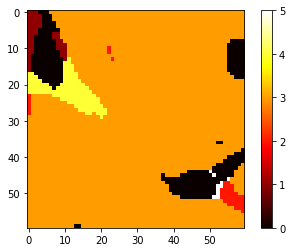

In [111]:
plot_heatmap()

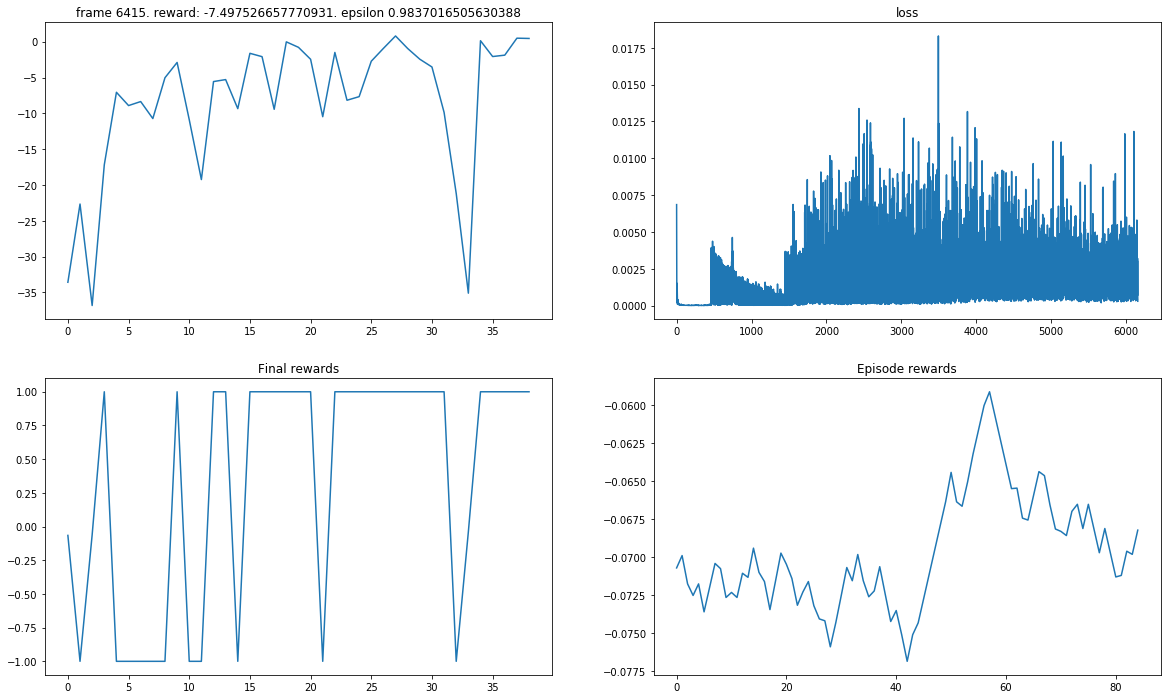

In [112]:
plot(frame_idx, all_rewards, losses, final_rewards, episode_reward_array)

In [35]:
torch.save(target_network.state_dict(), "model_DQN.pt")

In [38]:
env_id_test = "gym_stage_2:foo-v2"
env_test = gym.make(env_id)

In [40]:
state = env_test.reset()
frame = 0
success_times = 0
epochs = 0
total_frames = 0
while epochs < 49:
    env_test.render()
    action = target_network.takeAction(state, 0.2)
    next_state, reward, done, succeeded, reset_frame_for_episode = env_test.step(action)
    state = next_state
    frame += 1
    if done or frame % 500 ==0:
        epochs += 1
        total_frames += frame
        if reward > 0:
            success_times +=1
        frame = 0
        env_test.reset()
print("Sucess rates:", success_times / epochs)
print("Mean frame: ", total_frames / epochs)

Sucess rates: 0.6326530612244898
Mean frame:  183.0204081632653


In [121]:
## Loal Model. 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = DQNAgent(env.observation_space.shape[0], env.action_space.n)
checkPoint = torch.load("model_DQN2.pt")
loaded_model.load_state_dict(checkPoint)

loaded_model = loaded_model.to(device)
loaded_model.eval()

print(type(loaded_model))
#loaded_model.eval()

<class '__main__.DQNAgent'>


In [122]:
env_id_test = "gym_stage_2:foo-v2"
env_test = gym.make(env_id)
import time

In [125]:
state = env_test.reset()
frame = 0
success_times = 0
epochs = 0
all_frames = 0
while epochs < 49:
    #env_test.render()
    #time.sleep(0.1)
    action = loaded_model.takeAction(state, 0.4)
    next_state, reward, done, succeeded, reset_frame_for_episode = env_test.step(action)
    state = next_state
    frame += 1
    if done or frame % 500 ==0:
        all_frames += frame
        epochs += 1
        if reward > 0:
            success_times +=1
        frame = 0
        env_test.reset()
print("Sucess rate:", success_times / epochs)

Sucess rates: 0.8163265306122449
